# Analysis of interacting case for optimal variational parameters

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
import numpy as np

from vmc.interface import *
from vmc import run_all

from IPython.core.display import display

In [2]:
sns.set(color_codes=True)

In [3]:
SAVEFIG=True

In [4]:
mass = 1.0
omega = 1.0

radius = 0.0043
beta = _lambda = 2.82843

dw_radius = 2.0

num_particles = 50
num_dimensions = 3

step_length = 0.1
spread = 1

num_samples = int(2**20)
num_thermalization_steps = int(0.1*num_samples)

r_min = -4
r_max = 4
num_bins = 100


parameter_names = ["alpha"]
alpha = np.array([0.4974]).reshape(1, 1)
alpha_s = np.array([0.5]).reshape(1, 1)

kwargs = {
    "num_samples": num_samples, "step_length": step_length,
    "num_thermalization_steps": num_thermalization_steps}

In [5]:
sampler_i = PySampler(
    PyInteractingEllipticalGaussian(
        num_particles, num_dimensions, mass, omega, beta, radius,
        spread=spread
    ), PyEllipticalHarmonicOscillator(_lambda),
    PyImportanceMetropolis()
)

sampler_n = PySampler(
    PyInteractingEllipticalGaussian(
        num_particles, num_dimensions, mass, omega, beta, 0,
        spread=spread
    ), PyEllipticalHarmonicOscillator(_lambda),
    PyImportanceMetropolis()
)

sampler_s = PySampler(
    PySimpleGaussian(
        num_particles, num_dimensions, mass, omega, spread=spread
    ), PyHarmonicOscillator(),
    PyImportanceMetropolis()
)

#sampler_dw = PySampler(
#    PySimpleGaussian(
#        num_particles, num_dimensions, mass, omega, spread=np.sqrt(step_length)
#    ), PyDoubleWell(dw_radius),
#    PyImportanceMetropolis()
#)

sampler_i.initialize_one_body_densities(r_min, r_max, num_bins)
sampler_n.initialize_one_body_densities(r_min, r_max, num_bins)
sampler_s.initialize_one_body_densities(r_min, r_max, num_bins)
#sampler_dw.initialize_one_body_densities(r_min, r_max, num_bins)

In [6]:
df_i = run_all(sampler_i, alpha, parameter_names, 0, **kwargs)
df_i["energy_per_particle"] = df_i["energy"]/num_particles

100%|██████████| 1/1 [03:50<00:00, 230.75s/it]


In [7]:
display(df_i)

,alpha,energy,variance,std,acceptance,sampling_time,block_var,block_std,energy_per_particle
0,0.4974,127.28519,1.689754e-07,0.000411,0.957793,230.723805,0.000059,0.007657,2.545704


In [8]:
df_n = run_all(sampler_n, alpha, parameter_names, 0, **kwargs)
df_n["energy_per_particle"] = df_n["energy"]/num_particles

100%|██████████| 1/1 [01:30<00:00, 90.46s/it]


In [9]:
display(df_n)

,alpha,energy,variance,std,acceptance,sampling_time,block_var,block_std,energy_per_particle
0,0.4974,120.71287,6.399680e-09,0.00008,0.96314,90.435204,0.000001,0.001182,2.414257


In [10]:
df_s = run_all(sampler_s, alpha_s, parameter_names, 0, **kwargs)
df_s["energy_per_particle"] = df_s["energy"]/num_particles

100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


In [11]:
display(df_s)

,alpha,energy,variance,std,acceptance,sampling_time,block_var,block_std,energy_per_particle
0,0.5,75.0,0.0,0.0,0.985753,2.233548,0.0,0.0,1.5


In [12]:
#df_dw = run_all(sampler_dw, alpha_s, parameter_names, 0, **kwargs)
#df_dw["energy_per_particle"] = df_dw["energy"]/num_particles

In [13]:
#display(df_dw)

In [14]:
#bins_i = sampler_i.get_one_body_densities()
#bins_n = sampler_n.get_one_body_densities()
#bins_s = sampler_s.get_one_body_densities()
#bins_dw = sampler_dw.get_one_body_densities()
#radii = np.linspace(r_min, r_max, num_bins)

In [15]:
#fig = plt.figure()
#ax = fig.add_subplot(111, projection="3d")
#xv, yv = np.meshgrid(radii, radii)
#ax.plot_surface(xv, yv, np.outer(bins_dw[:, ::3], bins_dw[:, ::3]))
#plt.show()

In [16]:
#plt.contourf(radii, radii, np.outer(bins_dw[:, ::3], bins_dw[:, ::3]))
#plt.show()

In [17]:
def get_radial_densities(sampler):
    bins = np.linalg.norm(sampler.get_one_body_densities(), axis=1)
    return (bins[:bins.size//2])[::-1] + bins[bins.size//2:]

In [18]:
bins_i = get_radial_densities(sampler_i)
bins_n = get_radial_densities(sampler_n)
bins_s = get_radial_densities(sampler_s)

assert abs(r_max + r_min) < 1e-10, "Use symmetric bins"
assert bins_i.size == bins_n.size == bins_s.size, \
    "bins_i.size = {0}, bins_n.size = {1}, bins_s.size = {2}".format(
    bins_i.size, bins_n.size, bins_s.size)

radii = np.linspace(0, r_max, bins_i.size)

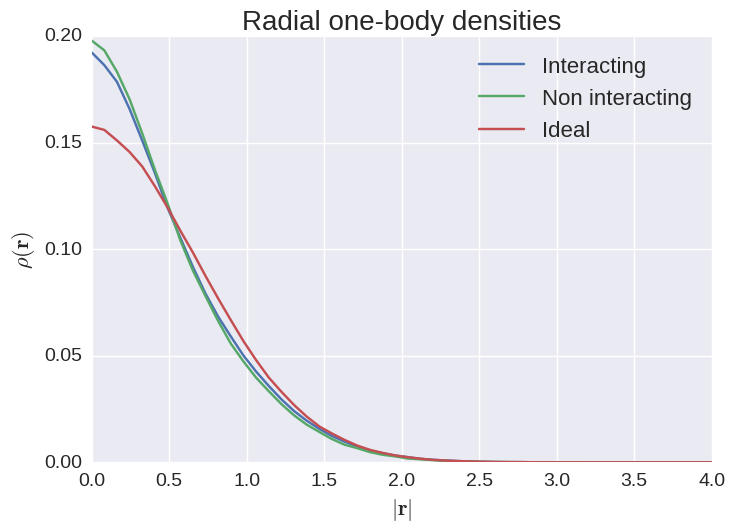

In [19]:
plt.plot(radii, bins_i, label=r"Interacting")
plt.plot(radii, bins_n, label=r"Non interacting")
plt.plot(radii, bins_s, label=r"Ideal")
#plt.plot(radii, np.linalg.norm(bins_dw, axis=1), label=r"Double Well")

plt.title(r"Radial one-body densities", fontsize=20)
plt.xlabel(r"$|\mathbf{r}|$", fontsize=16)
plt.ylabel(r"$\rho(\mathbf{r})$", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="best", fontsize=16)
if SAVEFIG:
    plt.savefig("../data/figures/problem_g_{0}N.pdf".format(num_particles))

plt.show()